## MiniPalindrome Experiment

The MiniPalindrome dataset consists of 48 Java programs in eight classes, each solving the task of detecting whether all words in the input string are palindromes. The classes represent different strategies to solve the tasks, e.g. whether using custom methods or built-in methods.

More information on the data set is available at [doi:10.4119/unibi/2900666](http://doi.org/10.4119/unibi/2900666).

In [1]:
# load the data
from edist.tree_utils import dataset_from_json
dataset_name = 'minipalindrome'
trees, filenames = dataset_from_json(dataset_name)

# label the data according to filename
X = []
Y = []
for i in range(len(trees)):
    if(filenames[i].startswith('ImplAAA')):
        Y.append(0)
    elif(filenames[i].startswith('ImplAAB')):
        Y.append(1)
    elif(filenames[i].startswith('ImplABA')):
        Y.append(2)
    elif(filenames[i].startswith('ImplABB')):
        Y.append(3)
    elif(filenames[i].startswith('ImplBAA')):
        Y.append(4)
    elif(filenames[i].startswith('ImplBAB')):
        Y.append(5)
    elif(filenames[i].startswith('ImplBBA')):
        Y.append(6)
    elif(filenames[i].startswith('ImplBBB')):
        Y.append(7)
    else:
        continue
    X.append(trees[i])

del trees
del filenames

import numpy as np
Y = np.array(Y)

In [2]:
# compute all pairwise tree edit distances
import edist.multiprocess as mp
import edist.ted as ted

D = mp.pairwise_distances_symmetric(X, ted.standard_ted)

In [3]:
# show the distances
import matplotlib.pyplot as plt
fig, axs = plt.subplots()
cax = axs.matshow(D)
fig.colorbar(cax)
plt.show()

<Figure size 640x480 with 2 Axes>

In [4]:
# set up possible C values for the SVM
Cs     = [0.1, 1., 10., 100.]

# pre-compute all kernel variations for all hyperparameter
# values
kernel_types = ['linear', 'RBF', 'ST', 'SST', 'PT']
Ks = [[], [], [], [], []]

# pre-compute linear kernel matrix via double centering
import scipy.linalg
d_row_mean = np.expand_dims(np.mean(D, axis=0), 1)
K_linear = 0.5 * (-D + d_row_mean + d_row_mean.T - np.mean(D))
Lambda, V = scipy.linalg.eig(K_linear)
Lambda[Lambda < 0] = 0
K_linear = np.real(np.dot(V, np.dot(np.diag(Lambda), V.T)))
Ks[0] = [K_linear]
del K_linear
del Lambda
del V

# pre-compute RBF kernel matrix
sigmas = np.array([0.1, 0.5, 1., 2.]) * np.mean(D)
for s in range(len(sigmas)):
    K = np.exp(-0.5 * np.square(D) / (sigmas[s] ** 2))
    K = 0.5 * (K + K.T)
    Lambda, V = scipy.linalg.eig(K)
    Lambda[Lambda < 0] = 0
    Ks[1].append(np.real(np.dot(V, np.dot(np.diag(Lambda), V.T))))
del K
del Lambda
del V

# prepare trees in PTK format
import ptk_utils
X_ptk = []
for x_nodes, x_adj in X:
    X_ptk.append(ptk_utils.to_ptk_tree(x_nodes, x_adj))
    
# pre-compute PTK kernel matrices
lambdas = [0.001, 0.01, 0.1]

for kernel_type in range(2, len(kernel_types)):
    for l in range(len(lambdas)):
        Ks[kernel_type].append(ptk_utils.pairwise_kernel_symmetric(X_ptk, kernel_types[kernel_type], lambdas[l]))

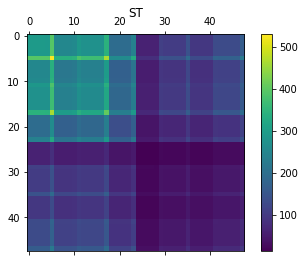

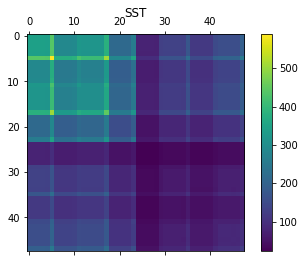

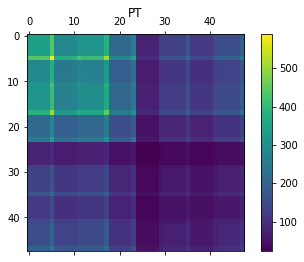

In [5]:
# show kernels
for kernel_type in range(2, len(kernel_types)):
    fig, axs = plt.subplots()
    cax = axs.matshow(Ks[kernel_type][-1])
    fig.colorbar(cax)
    plt.title(kernel_types[kernel_type])
    plt.show()

In [6]:
# set up out-of-sample methods for each kernel type
def oos_linear(x_nodes, x_adj, train_index):
    X_train = []
    for i in train_index:
        X_train.append(X[i])
    # compute the edit distances to all training data points
    d = mp.pairwise_distances([(x_nodes, x_adj)], X_train, ted.standard_ted)
    # compute the kernel values
    return 0.5 * (-d + np.mean(d) + np.mean(D[:, train_index], axis=0) - np.mean(D))
    
def oos_rbf(x_nodes, x_adj, train_index, sigma):
    X_train = []
    for i in train_index:
        X_train.append(X[i])
    # compute the edit distances to all training data points
    d = mp.pairwise_distances([(x_nodes, x_adj)], X_train, ted.standard_ted)
    # compute the kernel values
    return np.exp(-0.5 * np.square(d) / (sigma ** 2))
    
def oos_ptk(x_nodes, x_adj, train_index, kernel_type, lambda_):
    x = ptk_utils.to_ptk_tree(x_nodes, x_adj)
    X_train = []
    for i in train_index:
        X_train.append(ptk_utils.to_ptk_tree(X[i][0], X[i][1]))
    # compute the edit distances to all training data points
    return ptk_utils.pairwise_kernel([x], X_train, kernel_types[kernel_type], lambda_)

In [7]:
# gather the alphabet of out data set for recursive neural net computations
neural_net_types = ['recursive', 'tree echo state']

alphabet = set()
for i in range(len(X)):
    alphabet.update(X[i][0])
alphabet = list(alphabet)
alphabet.sort()
dim = 10
unique_labels = list(np.unique(Y))

# set up training functions for both neural net types
def recursive_train(X_train, Y_train):
    rec_net = RecursiveNetClassifier(dim, unique_labels, alphabet)
    learning_curve = rec_net.fit(X_train, Y_train, print_step = 100)
    print('completed training after %d steps' % len(learning_curve))
    return rec_net

dims = [10, 50, 100]
radii = [0.7, 0.9, 1., 1.5, 2]

def tree_echo_state_train(X_train, Y_train):
    # perform hyper-parameter optimization first
    dim, radius, _ = grid_search_cv_echo_state(X_train, Y_train, alphabet, dims, radii)
    print('finished hyper parameter optimization')
    # train tree echo state network
    rec_net = TreeEchoStateNetClassifier(dim, alphabet, radius=radius)
    rec_net.fit(X_train, Y_train)
    return rec_net

neural_net_train_funs = [recursive_train, tree_echo_state_train]

In [8]:
# set up crossvalidation folds
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from recursive_net import RecursiveNetClassifier
from tree_echo_state import TreeEchoStateNetClassifier
from hyperopt import grid_search_cv_svm
from hyperopt import grid_search_cv_echo_state
from adversarial_edits import construct_random_adversarials
from adversarial_edits import construct_adversarials

n_split_outer = 6
n_split_inner = 5

outer_cv = StratifiedKFold(n_splits=n_split_outer, shuffle=True)

# set up result matrices
conditions = ['original', 'random', 'adversarial']

accs = np.zeros((n_split_outer, len(kernel_types) + len(neural_net_types), len(conditions)))
d_adversarial = np.zeros((n_split_outer, len(kernel_types) + len(neural_net_types), len(conditions) - 1))
Zs = [[[None] * len(X)] * (len(kernel_types) + len(neural_net_types))] * (len(conditions) - 1)

# iterate over the folds
f = -1
for train_index, test_index in outer_cv.split(X, Y):
    f += 1
    print('--- fold %d of %d ---' % (f+1, n_split_outer))
    X_train = []
    for i in train_index:
        X_train.append(X[i])
    X_test = []
    for i in test_index:
        X_test.append(X[i])

    # iterate over our kernels
    for kernel_type in range(len(kernel_types)):
        print('%s kernel' % kernel_types[kernel_type])
        # perform a nested crossvalidation to optimize hyper-parameters
        C, k, _ = grid_search_cv_svm(Y, Cs, Ks[kernel_type], n_split_inner, train_index)
        print('finished hyper parameter optimization')
        # select the best kernel matrix
        K = Ks[kernel_type][k]
        K_train = K[train_index, :][:, train_index]
        K_test  = K[test_index, :][:, train_index]
        # train an SVM with the optimal hyperparameters
        svm = SVC(kernel='precomputed', decision_function_shape='ovo', C = C)
        svm.fit(K_train, Y[train_index])
        # evaluate the test accuracy
        Y_pred  = svm.predict(K_test)
        correct = Y[test_index] == Y_pred
        accs[f, kernel_type, 0] = accuracy_score(Y[test_index], Y_pred)
        print('accuracy: %g' % accs[f, kernel_type, 0])
        # then, start the adversarial construction on the test data
        # set up the out of sample function for the current kernel
        if(kernel_type == 0):
            oos = oos_linear
        elif(kernel_type == 1):
            oos = lambda x_nodes, x_adj, train_index: oos_rbf(x_nodes, x_adj, train_index, sigmas[k])
        else:
            oos = lambda x_nodes, x_adj, train_index: oos_ptk(x_nodes, x_adj, train_index, kernel_type, lambdas[k])
        # set up the predictive function for the current kernel
        def predict(x_nodes, x_adj):
            # compute the kernel values of the new point to the trainign data
            k = oos(x_nodes, x_adj, train_index)
            # and then predict with the SVM
            return svm.predict(k)
        # construct random adversarials
        Z, labels, ds = construct_random_adversarials(X_test, Y[test_index], Y_pred, predict, alphabet, max_d = 100)
        # verify labels
        success = np.logical_not(np.isinf(ds))
        if(np.any(labels[success] == Y[test_index][success])):
            raise ValueError('expected changed labels in all successful cases')
        # store the proportion of attempts where adversarial construction failed
        accs[f, kernel_type, 1] = np.mean(ds[correct] >= 1.)
        print('random adversarial accuracy: %g' % accs[f, kernel_type, 1])
        # the average relative distance to an adversarial example
        d_adversarial[f, kernel_type, 0] = np.mean(ds[success])
        # and the adversarial examples themselves
        for i in range(len(test_index)):
            Zs[0][kernel_type][test_index[i]] = Z[i]
        # construct adversarials
        Z, labels, ds = construct_adversarials(X_test, D[test_index, :][:, test_index], Y[test_index], Y_pred, predict)
        # verify labels
        success = np.logical_not(np.isinf(ds))
        if(np.any(labels[success] == Y[test_index][success])):
            raise ValueError('expected changed labels in all successful cases')
        # store the proportion of attempts where adversarial construction failed
        accs[f, kernel_type, 2] = np.mean(ds[correct] >= 1.)
        print('adversarial accuracy: %g' % accs[f, kernel_type, 2])
        # the average relative distance to an adversarial example
        d_adversarial[f, kernel_type, 1] = np.mean(ds[np.logical_not(np.isinf(ds))])
        # and the adversarial examples themselves
        for i in range(len(test_index)):
            Zs[1][kernel_type][test_index[i]] = Z[i]
    # also train the neural nets on this data
    for net_type in range(len(neural_net_types)):
        t = len(kernel_types) + net_type
        print('%s network' % neural_net_types[net_type])
        rec_net = neural_net_train_funs[net_type](X_train, Y[train_index])
        # check the accuracy
        Y_pred = np.array(rec_net.predict(X_test))
        correct = Y[test_index] == Y_pred
        accs[f, t, 0] = accuracy_score(Y[test_index], Y_pred)
        print('accuracy: %g' % accs[f, t, 0])
        # set up the predictive function
        def predict(x_nodes, x_adj):
            return rec_net.predict([(x_nodes, x_adj)])[0]
        # construct random adversarials
        Z, labels, ds = construct_random_adversarials(X_test, Y[test_index], Y_pred, predict, alphabet, max_d = 100)
        # verify labels
        success = np.logical_not(np.isinf(ds))
        if(np.any(labels[success] == Y[test_index][success])):
            raise ValueError('expected changed labels in all successful cases')
        # store the proportion of attempts where adversarial construction failed
        accs[f, t, 1] = np.mean(ds[correct] >= 1.)
        print('random adversarial accuracy: %g' % accs[f, t, 1])
        # the average relative distance to an adversarial example
        d_adversarial[f, t, 0] = np.mean(ds[success])
        # and the adversarial examples themselves
        for i in range(len(test_index)):
            Zs[0][t][test_index[i]] = Z[i]
        # construct adversarials
        Z, labels, ds = construct_adversarials(X_test, D[test_index, :][:, test_index], Y[test_index], Y_pred, predict)
        # verify labels
        success = np.logical_not(np.isinf(ds))
        if(np.any(labels[success] == Y[test_index][success])):
            raise ValueError('expected changed labels in all successful cases')
        # store the proportion of attempts where adversarial construction failed
        accs[f, t, 2] = np.mean(ds[correct] >= 1.)
        print('adversarial accuracy: %g' % accs[f, t, 2])
        # the average relative distnace to an adversarial example
        d_adversarial[f, t, 1] = np.mean(ds[success])
        # and the adversarial examples themselves
        for i in range(len(test_index)):
            Zs[1][t][test_index[i]] = Z[i]

/usr/lib64/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


--- fold 1 of 6 ---
linear kernel
finished hyper parameter optimization
accuracy: 1
random adversarial accuracy: 0.875
adversarial accuracy: 0.375
RBF kernel
finished hyper parameter optimization
accuracy: 1
random adversarial accuracy: 0.875
adversarial accuracy: 0.375
ST kernel
finished hyper parameter optimization
accuracy: 0.875
random adversarial accuracy: 0.142857
adversarial accuracy: 0.285714
SST kernel
finished hyper parameter optimization
accuracy: 1
random adversarial accuracy: 0.375
adversarial accuracy: 0.5
PT kernel
finished hyper parameter optimization
accuracy: 1
random adversarial accuracy: 0.25
adversarial accuracy: 0.5
recursive network
lowest loss after 100 steps: 1.86033
lowest loss after 200 steps: 1.81279
lowest loss after 300 steps: 1.4007
lowest loss after 400 steps: 1.24518
lowest loss after 500 steps: 1.09026
lowest loss after 600 steps: 1.00844
lowest loss after 700 steps: 0.948248
lowest loss after 800 steps: 0.945099
lowest loss after 900 steps: 0.929445
l

/usr/lib64/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


adversarial accuracy: 0.5
ST kernel
finished hyper parameter optimization
accuracy: 0.875
random adversarial accuracy: 0.285714
adversarial accuracy: 0.428571
SST kernel
finished hyper parameter optimization
accuracy: 1
random adversarial accuracy: 0.125
adversarial accuracy: 0.5
PT kernel
finished hyper parameter optimization
accuracy: 1
random adversarial accuracy: 0.125
adversarial accuracy: 0.5
recursive network
lowest loss after 100 steps: 1.95711
lowest loss after 200 steps: 1.90634
lowest loss after 300 steps: 1.4303
lowest loss after 400 steps: 1.25749
lowest loss after 500 steps: 1.15083
lowest loss after 600 steps: 1.15038
lowest loss after 700 steps: 1.11496
lowest loss after 800 steps: 1.07781
lowest loss after 900 steps: 0.956865
lowest loss after 1000 steps: 0.760594
lowest loss after 1100 steps: 0.736289
lowest loss after 1200 steps: 0.639591
lowest loss after 1300 steps: 0.509379
lowest loss after 1400 steps: 0.470638
lowest loss after 1500 steps: 0.470638
lowest loss a

lowest loss after 400 steps: 1.11417
lowest loss after 500 steps: 1.11417
lowest loss after 600 steps: 1.09055
lowest loss after 700 steps: 1.04761
lowest loss after 800 steps: 0.927535
lowest loss after 900 steps: 0.769634
lowest loss after 1000 steps: 0.710515
lowest loss after 1100 steps: 0.687182
lowest loss after 1200 steps: 0.673491
lowest loss after 1300 steps: 0.602877
lowest loss after 1400 steps: 0.555081
lowest loss after 1500 steps: 0.471385
lowest loss after 1600 steps: 0.436517
lowest loss after 1700 steps: 0.436517
lowest loss after 1800 steps: 0.328267
lowest loss after 1900 steps: 0.197429
lowest loss after 2000 steps: 0.197429
lowest loss after 2100 steps: 0.197429
lowest loss after 2200 steps: 0.197429
lowest loss after 2300 steps: 0.197429
lowest loss after 2400 steps: 0.162603
lowest loss after 2500 steps: 0.11293
lowest loss after 2600 steps: 0.104627
lowest loss after 2700 steps: 0.104627
lowest loss after 2800 steps: 0.0956619
lowest loss after 2900 steps: 0.095

lowest loss after 4400 steps: 0.0182426
lowest loss after 4500 steps: 0.0148477
lowest loss after 4600 steps: 0.0148477
lowest loss after 4700 steps: 0.0135227
lowest loss after 4800 steps: 0.0132329
lowest loss after 4900 steps: 0.0107851
lowest loss after 5000 steps: 0.0107851
lowest loss after 5100 steps: 0.0107851
completed training after 5113 steps
accuracy: 0.875
random adversarial accuracy: 0.285714
adversarial accuracy: 0.142857
tree echo state network
finished hyper parameter optimization
accuracy: 0.875
random adversarial accuracy: 0.142857
adversarial accuracy: 0.428571


In [9]:
for kernel_type in range(len(kernel_types)):
    print('%s kernel' % kernel_types[kernel_type])
    print('on average, we needed the following distance to flip the label: %g' % np.mean(d_adversarial[:, kernel_type, -1]))
    print('we could generate adversarial examples for %g%% of the data' % (100. - 100.* np.mean(accs[:, kernel_type, -1])))
for net_type in range(len(neural_net_types)):
    t = len(kernel_types) + net_type
    print('%s network' % neural_net_types[net_type])
    print('on average, we needed the following distance to flip the label: %g' % np.mean(d_adversarial[:, t, -1]))
    print('we could generate adversarial examples for %g%% of the data' % (100. - 100.* np.mean(accs[:, t, -1])))

linear kernel
on average, we needed the following distance to flip the label: 2.68068
we could generate adversarial examples for 52.0833% of the data
RBF kernel
on average, we needed the following distance to flip the label: 1.43975
we could generate adversarial examples for 52.0833% of the data
ST kernel
on average, we needed the following distance to flip the label: 0.933978
we could generate adversarial examples for 71.9246% of the data
SST kernel
on average, we needed the following distance to flip the label: 1.90993
we could generate adversarial examples for 53.869% of the data
PT kernel
on average, we needed the following distance to flip the label: 1.90993
we could generate adversarial examples for 53.869% of the data
recursive network
on average, we needed the following distance to flip the label: 1.25805
we could generate adversarial examples for 78.7103% of the data
tree echo state network
on average, we needed the following distance to flip the label: 1.57397
we could genera

In [10]:
# print the results to a CSV table
np.savetxt('results/%s_accs.csv' % dataset_name, accs[:, :, 0], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')
np.savetxt('results/%s_accs_random_adversarial.csv' % dataset_name, accs[:, :, 1], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')
np.savetxt('results/%s_d_random_adversarial.csv' % dataset_name, d_adversarial[:, :, 0], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')
np.savetxt('results/%s_accs_adversarial.csv' % dataset_name, accs[:, :, 2], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')
np.savetxt('results/%s_d_adversarial.csv' % dataset_name, d_adversarial[:, :, 1], delimiter='\t', header='\t'.join(kernel_types + neural_net_types), fmt='%g')

In [11]:
# print the adversarial examples to a pickle file
import pickle
with open('results/%s_adversarials.pickle' % dataset_name, 'wb') as pickle_file:
    pickle.dump(Zs, pickle_file)